In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas
import os
import pingouin
import datapungibea as dpb
from matplotlib.patches import ArrowStyle
import copy
from matplotlib.backends.backend_pdf import PdfPages
import networkx as nx
from pgmpy.estimators import PC
import statsmodels.api as sm
import plotly.express as px
from sklearn.linear_model import LinearRegression
import seaborn as sns
import random
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.metrics import mean_squared_error, accuracy_score
from statsmodels.discrete.discrete_model import Logit
from networkx.drawing.nx_agraph import graphviz_layout
from collections import defaultdict
import math


C:\Users\abiodun.idowu\Anaconda3\envs\python37\lib\site-packages\geopandas\_compat.py:115: UserWarning: The Shapely GEOS version (3.4.3-CAPI-1.8.3 r4285) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string
C:\Users\abiodun.idowu\Anaconda3\envs\python37\lib\site-packages\outdated\utils.py:18: OutdatedPackageWarning: The package outdated is out of date. Your version is 0.2.1, the latest is 0.2.2.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs
C:\Users\abiodun.idowu\Anaconda3\envs\python37\lib\site-packages\outdated\utils.py:18: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.2, the latest is 0.5.4.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs
C:\Users\abiodun.idowu\Anaconda3\envs\python37\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Ple

In [2]:
from abbeyFunctions import graph_DAG, create_cluster_dags, determine_p_value, graph_DAG_cluster, get_edges_dict, get_col_shared_edges, get_row_shared_edges, plot_shared_edges

In [3]:
ai_data_nominal = pd.read_csv('nominal_data.csv')

In [4]:
ai_data_real = pd.read_csv('real_data.csv')

In [5]:
ai_data_nominal = ai_data_nominal.set_index(['FIPS_y', 'TimePeriod'])

In [6]:
ai_data_real = ai_data_real.set_index(['FIPS_y', 'TimePeriod'])

In [7]:
exclude_vars = ['M4 I','RM4I', 'unem']  # List of variables to exclude

# Create a dictionary to store the dataframes
ai_dct = {"logged_n": ai_data_nominal.copy(), "logged_r": ai_data_real.copy(), 
          "rates_n": ai_data_nominal.copy(), "rates_r": ai_data_real.copy(),
         "percent rates_n": ai_data_nominal.copy(), 
          "percent rates_r": ai_data_real.copy()}

        
for col in ai_dct['logged_n'].columns:
    if col not in exclude_vars:
        ai_dct["logged_n"][col] = np.log(ai_data_nominal[col]).replace([np.inf, -np.inf], np.nan)

for col in ai_dct['logged_r'].columns:
    if col not in exclude_vars:
        ai_dct["logged_r"][col] = np.log(ai_data_real[col]).replace([np.inf, -np.inf], np.nan)


# Calculate rate of change (differences of log-transformed values)
for col in ai_dct['rates_n'].columns:
    if col not in exclude_vars:
        ai_dct["rates_n"][col] = ai_dct["logged_n"].groupby('FIPS_y')[col].diff().dropna()
        
        

for col in ai_dct['rates_r'].columns:
    if col not in exclude_vars:
        ai_dct["rates_r"][col] = ai_dct["logged_r"].groupby('FIPS_y')[col].diff().dropna()
        
        
        # Calculate percent rate of change
for col in ai_dct['percent rates_n'].columns:
    #if col not in exclude_vars:
        ai_dct["percent rates_n"][col] = ai_dct["rates_n"].groupby('FIPS_y')[col].diff().dropna()

        
        
for col in ai_dct['percent rates_r'].columns:
    #if col not in exclude_vars:
        ai_dct["percent rates_r"][col] = ai_dct["rates_r"].groupby('FIPS_y')[col].diff().dropna()

        
        

C:\Users\abiodun.idowu\Anaconda3\envs\python37\lib\site-packages\pandas\core\arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\abiodun.idowu\Anaconda3\envs\python37\lib\site-packages\pandas\core\arraylike.py:364: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [8]:
nominal = ai_dct['rates_n']

In [9]:
nominal.drop(columns=['All ', 'Neig'], inplace=True)

In [10]:
diff_nominal = ai_dct['percent rates_n']

In [11]:
diff_nominal.drop(columns=['All ', 'Neig'], inplace=True)

In [12]:
real = ai_dct['rates_r']

In [13]:
real.drop(columns=['All ', 'Neig'], inplace=True)

In [14]:
diff_real = ai_dct['percent rates_r']

In [15]:
diff_real.drop(columns=['All ', 'Neig'], inplace=True)

In [16]:
# nominal.to_csv('nominal.csv', index=True)
# diff_nominal.to_csv('diff_nominal.csv', index=True)
# real.to_csv('real.csv', index=True)
# diff_real.to_csv('diff_real.csv', index=True)

In [17]:
ai_df_nom = pd.read_csv('nominal_kml3d.csv')

ai_df_diffnom = pd.read_csv('diff_nominal_kml3d.csv')

ai_df_real = pd.read_csv('real_kml3d.csv')

ai_df_diffreal = pd.read_csv('diff_real_kml3d.csv')

In [18]:
level_11 = ai_df_nom

level_12 = ai_df_diffnom

level_21 = ai_df_real

level_22 = ai_df_diffreal

In [19]:
dfg_ai11 = nominal.dropna()

dfg_ai12 = diff_nominal.dropna()

dfg_ai21 = real.dropna()

dfg_ai22 = diff_real.dropna()

In [20]:
ai_merge11 = pd.merge(dfg_ai11, level_11[['FIPS_y', 'clusters']], on='FIPS_y', how='left')

In [21]:
ai_merge12 = pd.merge(dfg_ai12, level_12[['FIPS_y', 'clusters']], on='FIPS_y', how='left')

In [22]:
ai_merge21 = pd.merge(dfg_ai21, level_21[['FIPS_y', 'clusters']], on='FIPS_y', how='left')

In [23]:
ai_merge22 = pd.merge(dfg_ai22, level_22[['FIPS_y', 'clusters']], on='FIPS_y', how='left')

In [24]:
kml3d_ai_level11 = ai_merge11.dropna()

In [25]:
kml3d_ai_level12 = ai_merge12.dropna()

In [26]:
kml3d_ai_level21 = ai_merge21.dropna()

In [27]:
kml3d_ai_level22 = ai_merge22.dropna()

In [28]:
kml3d_ai_level11 = kml3d_ai_level11.set_index(['FIPS_y'])

In [29]:
kml3d_ai_level12 = kml3d_ai_level12.set_index(['FIPS_y'])

In [30]:
kml3d_ai_level21 = kml3d_ai_level21.set_index(['FIPS_y'])

In [31]:
kml3d_ai_level22 = kml3d_ai_level22.set_index(['FIPS_y'])

In [32]:
cluster_mapping = {'A': 1, 'B': 2, 'C': 3, 'D': 4}

In [33]:
kml3d_ai_level11['clusters'].replace(cluster_mapping, inplace=True)

In [34]:
kml3d_ai_level12['clusters'].replace(cluster_mapping, inplace=True)

In [35]:
kml3d_ai_level21['clusters'].replace(cluster_mapping, inplace=True)

In [36]:
kml3d_ai_level22['clusters'].replace(cluster_mapping, inplace=True)

In [37]:
nr_11 = kml3d_ai_level11
nr_13 = kml3d_ai_level12
rr_21 = kml3d_ai_level21
rr_23 = kml3d_ai_level22

In [38]:
nr_12 = nr_11.copy()
nr_14 = nr_13.copy()
rr_22 = rr_21.copy()
rr_24 = rr_23.copy()

In [39]:
rr_22.columns

Index(['Agri', 'Mini', 'Util', 'RM4_', 'RM4I', 'unem', 'clusters'], dtype='object')

In [40]:
nr_12.drop(columns=['M4_y', 'M4 I'], inplace=True)
nr_14.drop(columns=['M4_y', 'M4 I'], inplace=True)

rr_22.drop(columns=['RM4_', 'RM4I'], inplace=True)
rr_24.drop(columns=['RM4_', 'RM4I'], inplace=True)

In [41]:
plot_df2 = nominal.copy()
plot_df4 = diff_nominal.copy()
plot_df6 = real.copy()
plot_df8 = diff_real.copy()

In [42]:
real.columns

Index(['Agri', 'Mini', 'Util', 'RM4_', 'RM4I', 'unem'], dtype='object')

In [43]:
plot_df1 = nominal.dropna()
plot_df2.drop(columns=['M4_y', 'M4 I'], inplace=True)
plot_df3 = diff_nominal.dropna()
plot_df4.drop(columns=['M4_y', 'M4 I'], inplace=True)
plot_df5 = real.dropna()
plot_df6.drop(columns=['RM4_', 'RM4I'], inplace=True)
plot_df7 = diff_real.dropna()
plot_df8.drop(columns=['RM4_', 'RM4I'], inplace=True)

In [44]:
plot_df1 = plot_df1.dropna()
plot_df2 = plot_df2.dropna()
plot_df3 = plot_df3.dropna()
plot_df4 = plot_df4.dropna()
plot_df5 = plot_df5.dropna()
plot_df6 = plot_df6.dropna()
plot_df7 = plot_df7.dropna()
plot_df8 = plot_df8.dropna()


Working for n conditional variables: 4: 100%|████████████████████████████████████████████| 4/4 [00:00<00:00,  5.46it/s]


keep control: Util
keep control: M4_y
('Mini', 'unem') ['Util', 'M4_y']
('unem', 'M4 I') []
keep control: Util
keep control: Mini
('M4_y', 'unem') ['Util', 'Mini']
keep control: Util
('M4 I', 'M4_y') ['Util']
('M4 I', 'Mini') []
keep control: M4 I
('Util', 'M4_y') ['M4 I']
keep control: M4_y
keep control: Mini
('Util', 'unem') ['M4_y', 'Mini']


Working for n conditional variables: 4: 100%|████████████████████████████████████████████| 4/4 [00:00<00:00,  6.83it/s]


('unem', 'Mini') []
keep control: Mini
('unem', 'M4 I') ['Mini']
keep control: unem
('Mini', 'M4 I') ['unem']
keep control: Agri
('Util', 'M4_y') ['Agri']
('M4_y', 'unem') []
keep control: Util
('Agri', 'M4_y') ['Util']


Working for n conditional variables: 4: 100%|████████████████████████████████████████████| 4/4 [00:00<00:00,  6.83it/s]


keep control: Util
keep control: unem
('RM4_', 'RM4I') ['Util', 'unem']
('RM4_', 'Mini') []
('RM4_', 'Util') []
('RM4_', 'Agri') []
keep control: Util
keep control: RM4_
('unem', 'RM4I') ['Util', 'RM4_']
keep control: unem
keep control: RM4_
('Util', 'RM4I') ['unem', 'RM4_']
keep control: Agri
keep control: Mini
('Util', 'RM4_') ['Agri', 'Mini']
keep control: Util
keep control: Agri
('Mini', 'RM4_') ['Util', 'Agri']
keep control: Util
keep control: Mini
('Agri', 'RM4_') ['Util', 'Mini']


Working for n conditional variables: 2: 100%|████████████████████████████████████████████| 2/2 [00:00<00:00,  5.75it/s]


keep control: Util
keep control: unem
('Mini', 'Agri') ['Util', 'unem']
('Mini', 'Util') []
keep control: Util
keep control: Mini
('unem', 'Agri') ['Util', 'Mini']
keep control: unem
keep control: Mini
('Util', 'Agri') ['unem', 'Mini']
('Util', 'Mini') []


Working for n conditional variables: 4: 100%|████████████████████████████████████████████| 4/4 [00:00<00:00,  5.01it/s]


keep control: Util
keep control: RM4_
('Mini', 'RM4I') ['Util', 'RM4_']
('Mini', 'unem') []
keep control: Util
('Mini', 'RM4_') ['Util']
keep control: Util
keep control: Mini
('RM4_', 'RM4I') ['Util', 'Mini']
('RM4_', 'Agri') []
('RM4_', 'Mini') []
('RM4_', 'Util') []
keep control: RM4_
keep control: Mini
('Util', 'RM4I') ['RM4_', 'Mini']
keep control: Mini
('Util', 'RM4_') ['Mini']


Working for n conditional variables: 2: 100%|████████████████████████████████████████████| 2/2 [00:00<00:00,  5.71it/s]


keep control: Util
keep control: unem
('Mini', 'Agri') ['Util', 'unem']
keep control: Agri
('Mini', 'unem') ['Agri']
keep control: Agri
('Mini', 'Util') ['Agri']
keep control: Util
keep control: unem
('Agri', 'Mini') ['Util', 'unem']
keep control: Mini
('Agri', 'unem') ['Mini']
keep control: Mini
('Agri', 'Util') ['Mini']
keep control: Util
keep control: Agri
('unem', 'Mini') ['Util', 'Agri']
keep control: Util
keep control: Mini
('unem', 'Agri') ['Util', 'Mini']
keep control: unem
keep control: Agri
('Util', 'Mini') ['unem', 'Agri']
keep control: unem
keep control: Mini
('Util', 'Agri') ['unem', 'Mini']


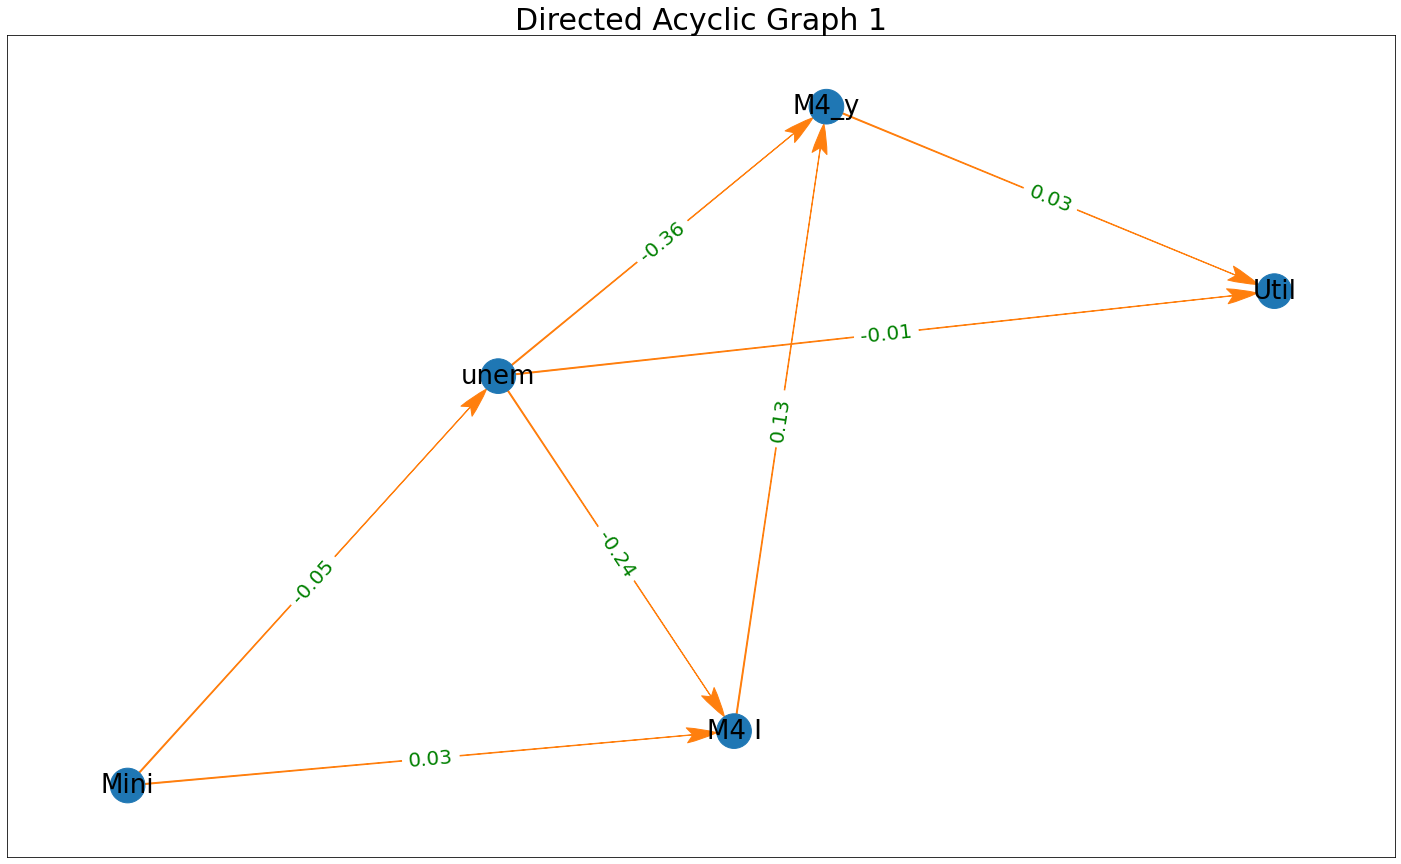

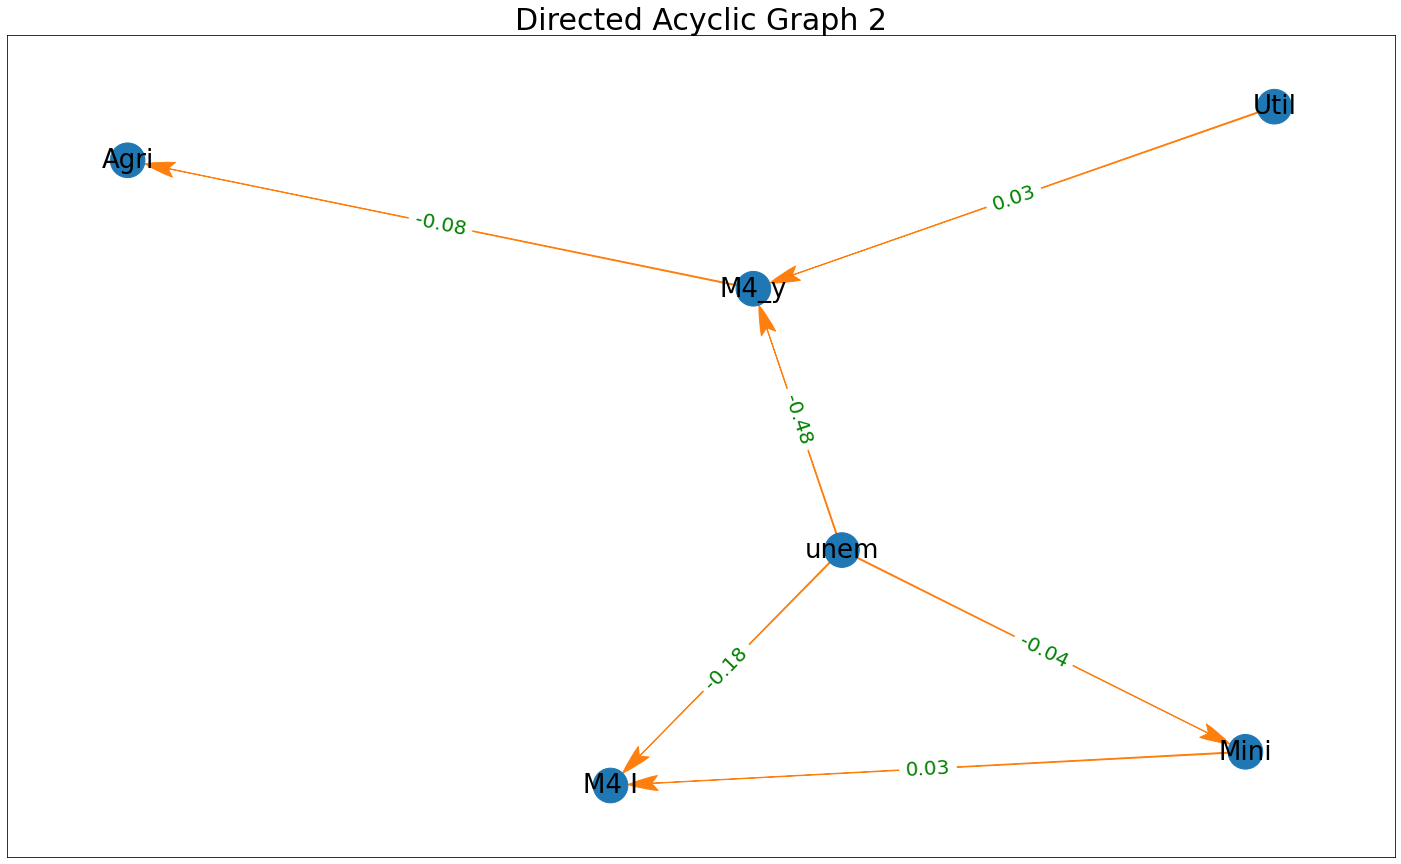

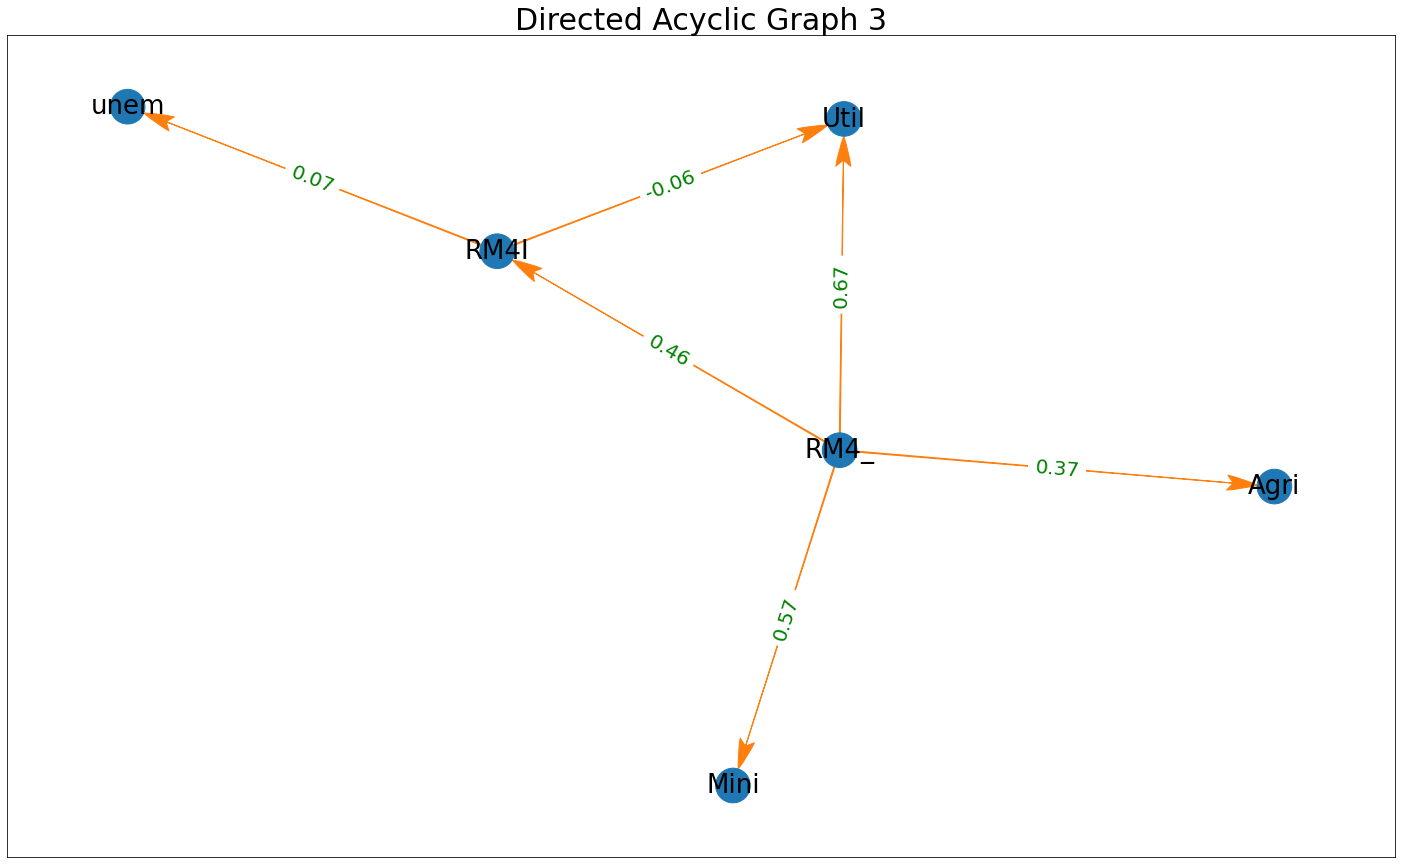

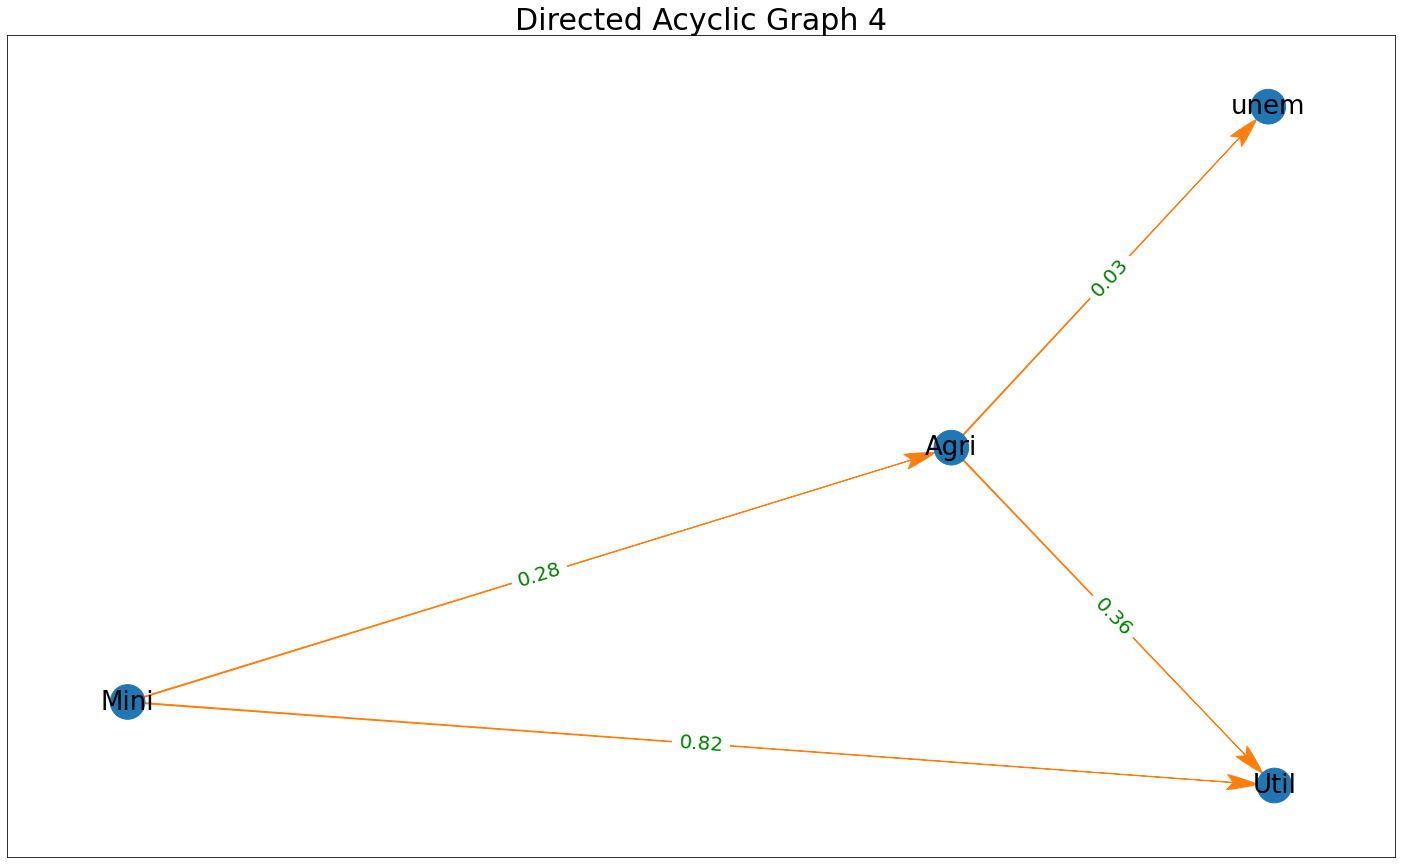

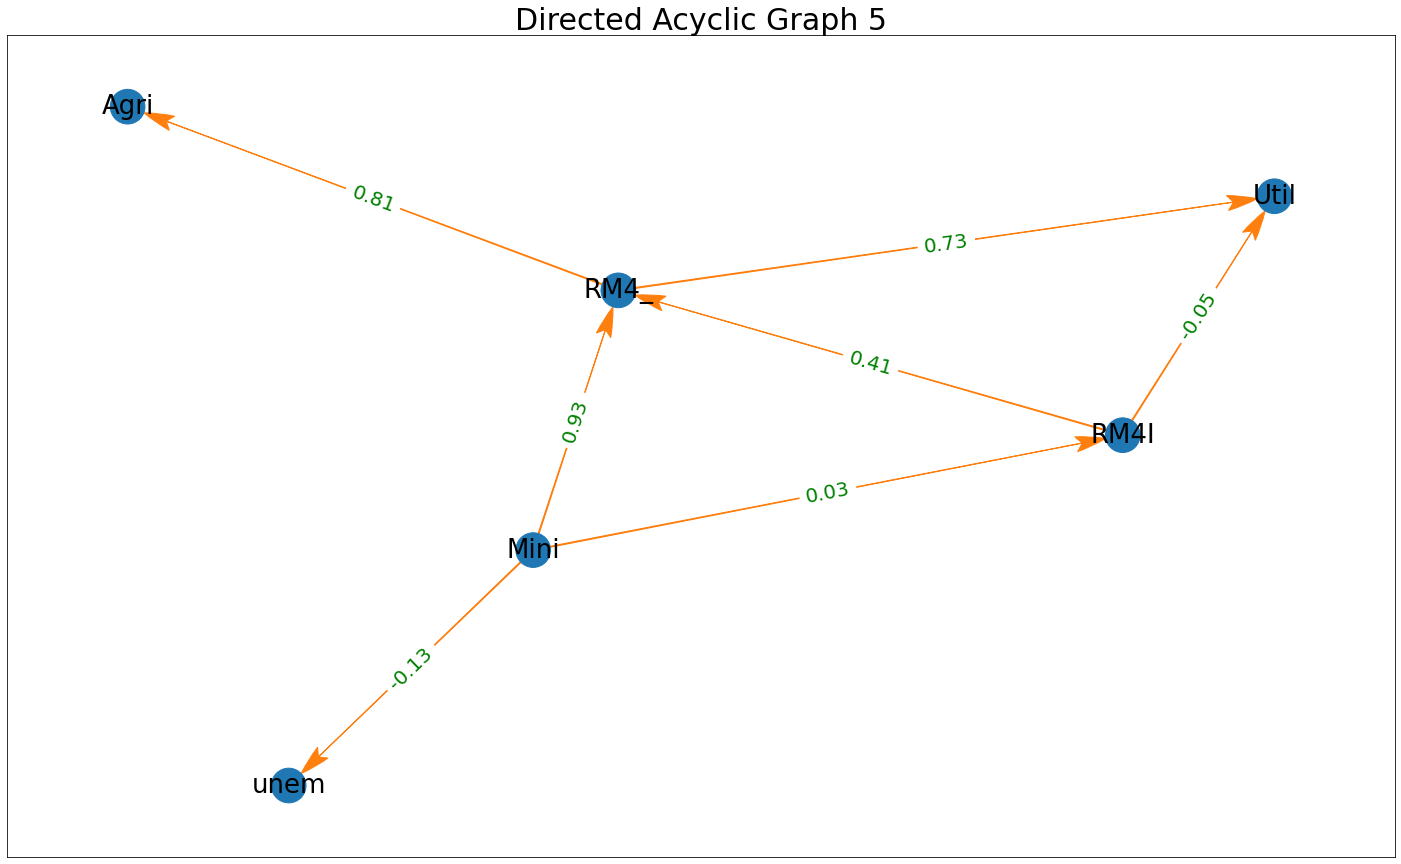

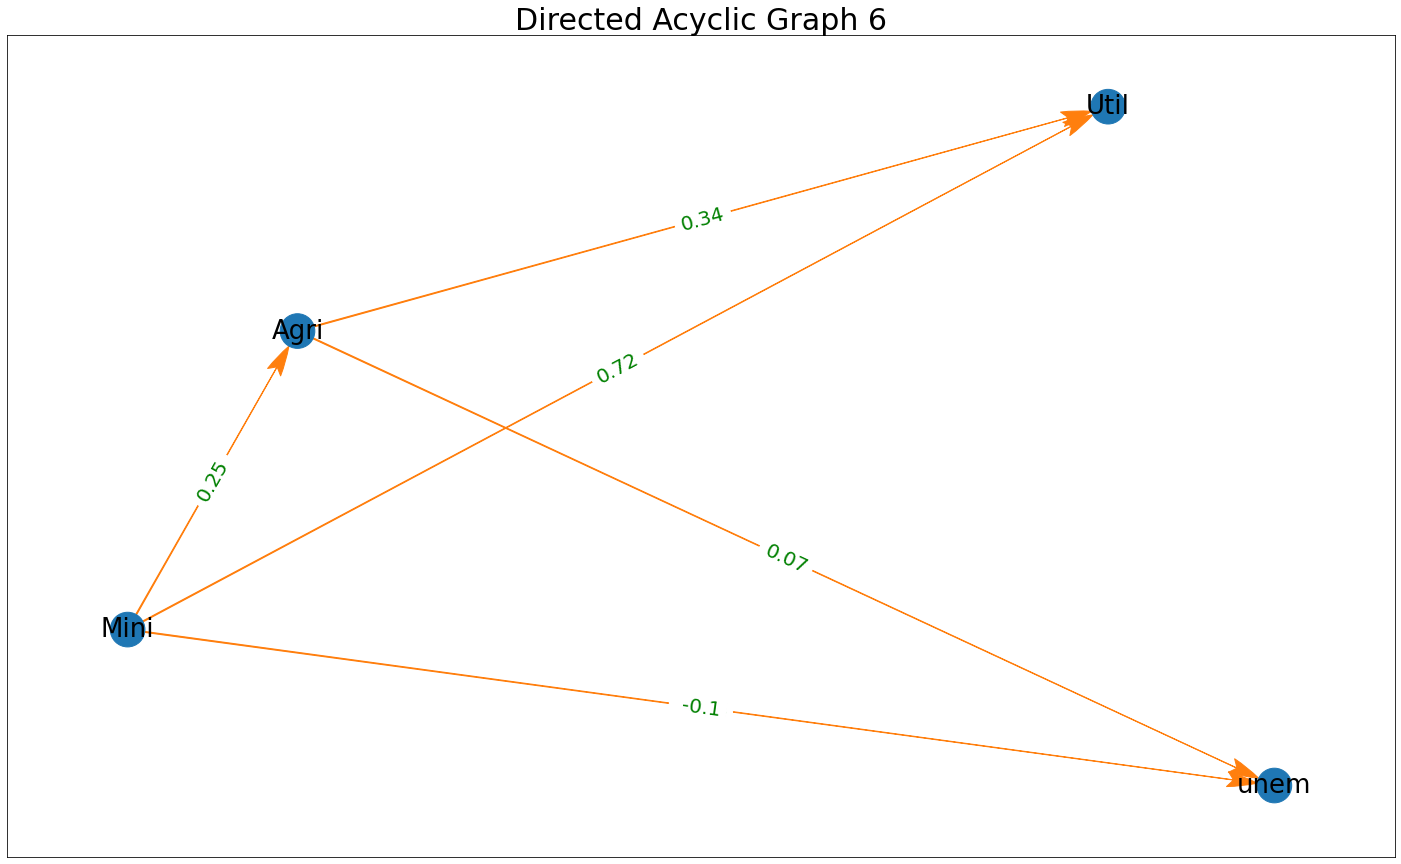

In [45]:
# Initialize a PdfPages object to save the plots in a PDF
pp = PdfPages("DAGs_nominal vs real.pdf")

# Plot DAGs for each dataframe
for i, plot_df in enumerate([plot_df1, plot_df3, plot_df5, plot_df6, plot_df7, plot_df8]):
    c = PC(plot_df)
    max_cond_vars = len(plot_df.keys()) - 2
    model = c.estimate(return_type='pdag', variant='parallel', significance_level=0.01,
                       max_cond_vars=max_cond_vars, ci_test='pearsonr')
    edges = model.edges

    # Plot the DAG
    graph_DAG(edges, plot_df, title=f'Directed Acyclic Graph {i+1}')
    
    # Save the plot to the PDF
    pp.savefig()

# Close the PdfPages object
pp.close()

### DAGs representing nominal rates and real rates:

Where;

nr_11 represents nominal rates with all variables (except neighbor's GDP and total GDP),

rr_21 represents real rates with all variables (except neighbor's GDP and total GDP), and

rr_22 represents real rates without M4 and interest rates and without neighbor and total GDP

In [46]:
# List of dataframes
dataframes = [nr_11, rr_21, rr_22]

# List of p-values for each dataframe
p_values_list = [0.1, 0.05, 0.01, 0.001]  # Updated to include p-values for each dataframe

# Define names for the output files based on dataframes
output_names = [f'clusters_b{i+1}' for i in range(len(dataframes))]

Working for n conditional variables: 3:  60%|█████████████████████████▊                 | 3/5 [00:00<00:00, 211.85it/s]


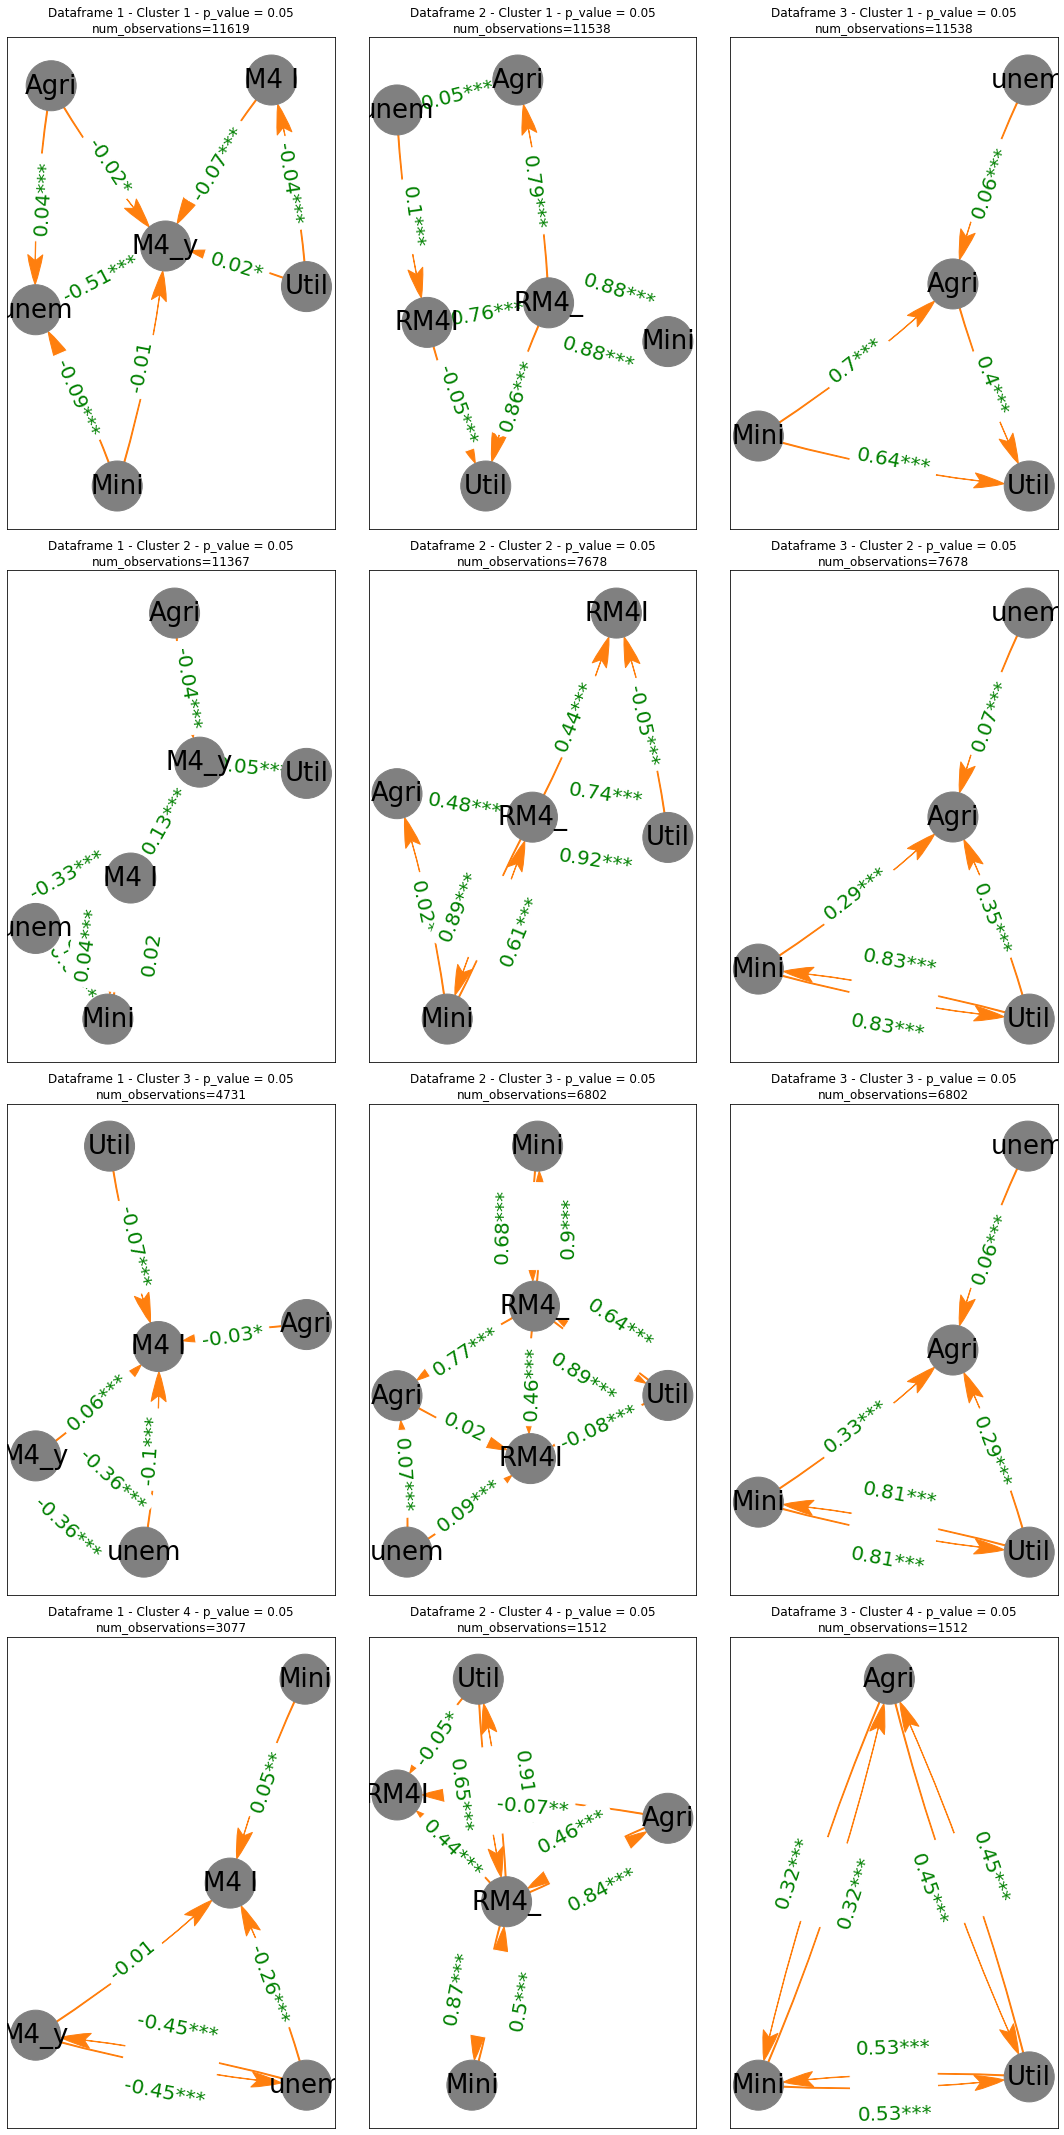

In [47]:
# Specify the absolute path for the output PDF file
#pdf_file_path = "DAGS for rates nominal vs real with clusters.pdf"
#f"DAGOutputs_{len(dataframes)}_dataframes.pdf"
pp = PdfPages("DAGS for rates nominal vs real with clusters.pdf")

# Create a grid for the subplots
fig, axes = plt.subplots(4, len(dataframes), figsize=(5*len(dataframes), 30))

# Different PC algorithms to test
algorithms = ["orig"]

# Iterate over each dataframe
for idx, dataframe in enumerate(dataframes):
    # Get clustered dataframes for the current dataframe
    clustered_dfs = create_cluster_dags(dataframe)

    # Iterate over clustered dataframes and determine p-values dynamically
    for cluster_idx, cluster_df in enumerate(clustered_dfs):
        n = cluster_df.shape[0]  # Number of observations for the current cluster
        p_value = determine_p_value(n)

        # Iterate over different PC algorithms
        for algorithm in algorithms:
            c = PC(cluster_df)
            model = c.estimate(return_type='pdag', variant=algorithm, significance_level=p_value, ci_test='pearsonr')
            edges = model.edges

            # Create DAG for the current cluster, p-value, and algorithm using the modified graph_DAG function
            graph_DAG_cluster(edges, cluster_df, title=f'Dataframe {idx + 1} - Cluster {cluster_idx + 1} - p_value = {p_value}\nnum_observations={n}'
                      , algorithm=algorithm, ax=axes[cluster_idx, idx])

# Save the figure to the PDF
pp.savefig(fig, bbox_inches='tight')

pp.close()
plt.show()


In [48]:
edges_dct = get_edges_dict(dataframes)

Working for n conditional variables: 3:  60%|█████████████████████████▊                 | 3/5 [00:00<00:00, 275.27it/s]


In [49]:
col_shared_edges=get_col_shared_edges(edges_dct)

In [50]:
row_shared_edges=get_row_shared_edges(edges_dct)
row_shared_edges

{0: [('Agri', 'unem')], 1: [], 2: [], 3: []}

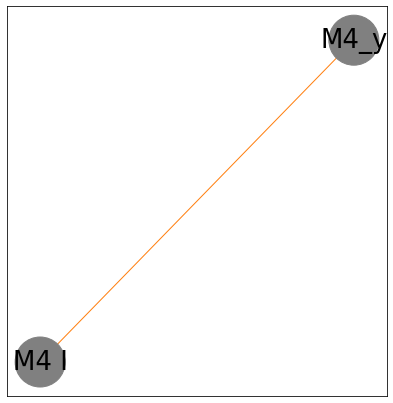

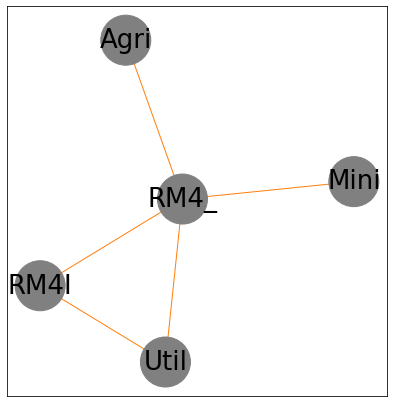

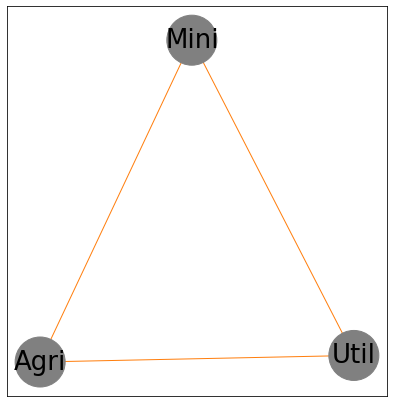

In [51]:
plot_shared_edges(col_shared_edges)

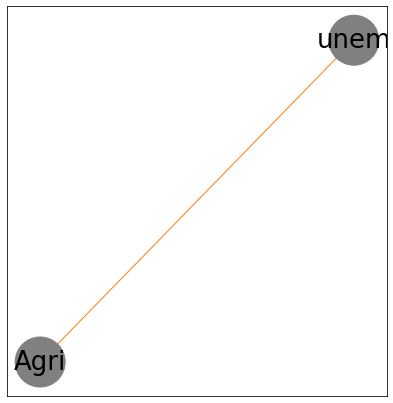

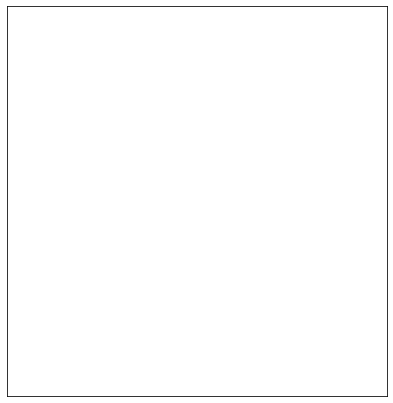

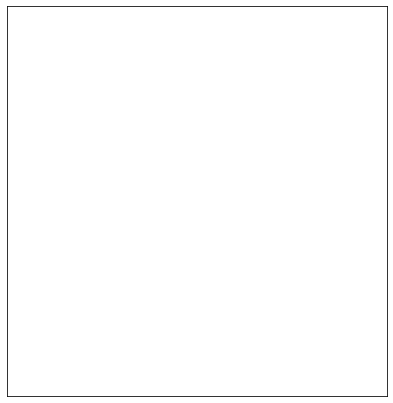

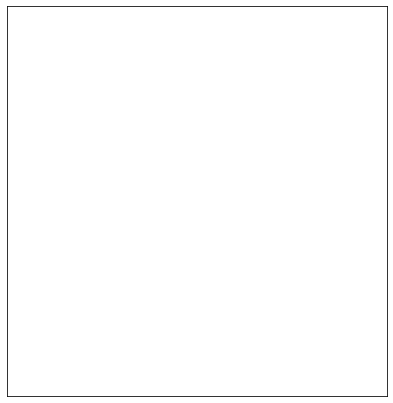

In [52]:
plot_shared_edges(row_shared_edges)

### DAGs representing first difference rates

Where;

nr_13 represents differenced nominal rates with all variables (except neighbor and total GDP),

rr_23 represents differenced real rates with all variables (except neighbor and total GDP), and

rr_24 represents differenced real rates without M4 and interest rates and without neighbor and total GDP

In [53]:
# List of dataframes
dataframes = [nr_13, rr_23, rr_24]

# List of p-values for each dataframe
p_values_list = [0.1, 0.05, 0.01, 0.001]  # Updated to include p-values for each dataframe

# Define names for the output files based on dataframes
output_names = [f'clusters_b{i+1}' for i in range(len(dataframes))]

Working for n conditional variables: 4:  80%|██████████████████████████████████▍        | 4/5 [00:00<00:00, 108.41it/s]


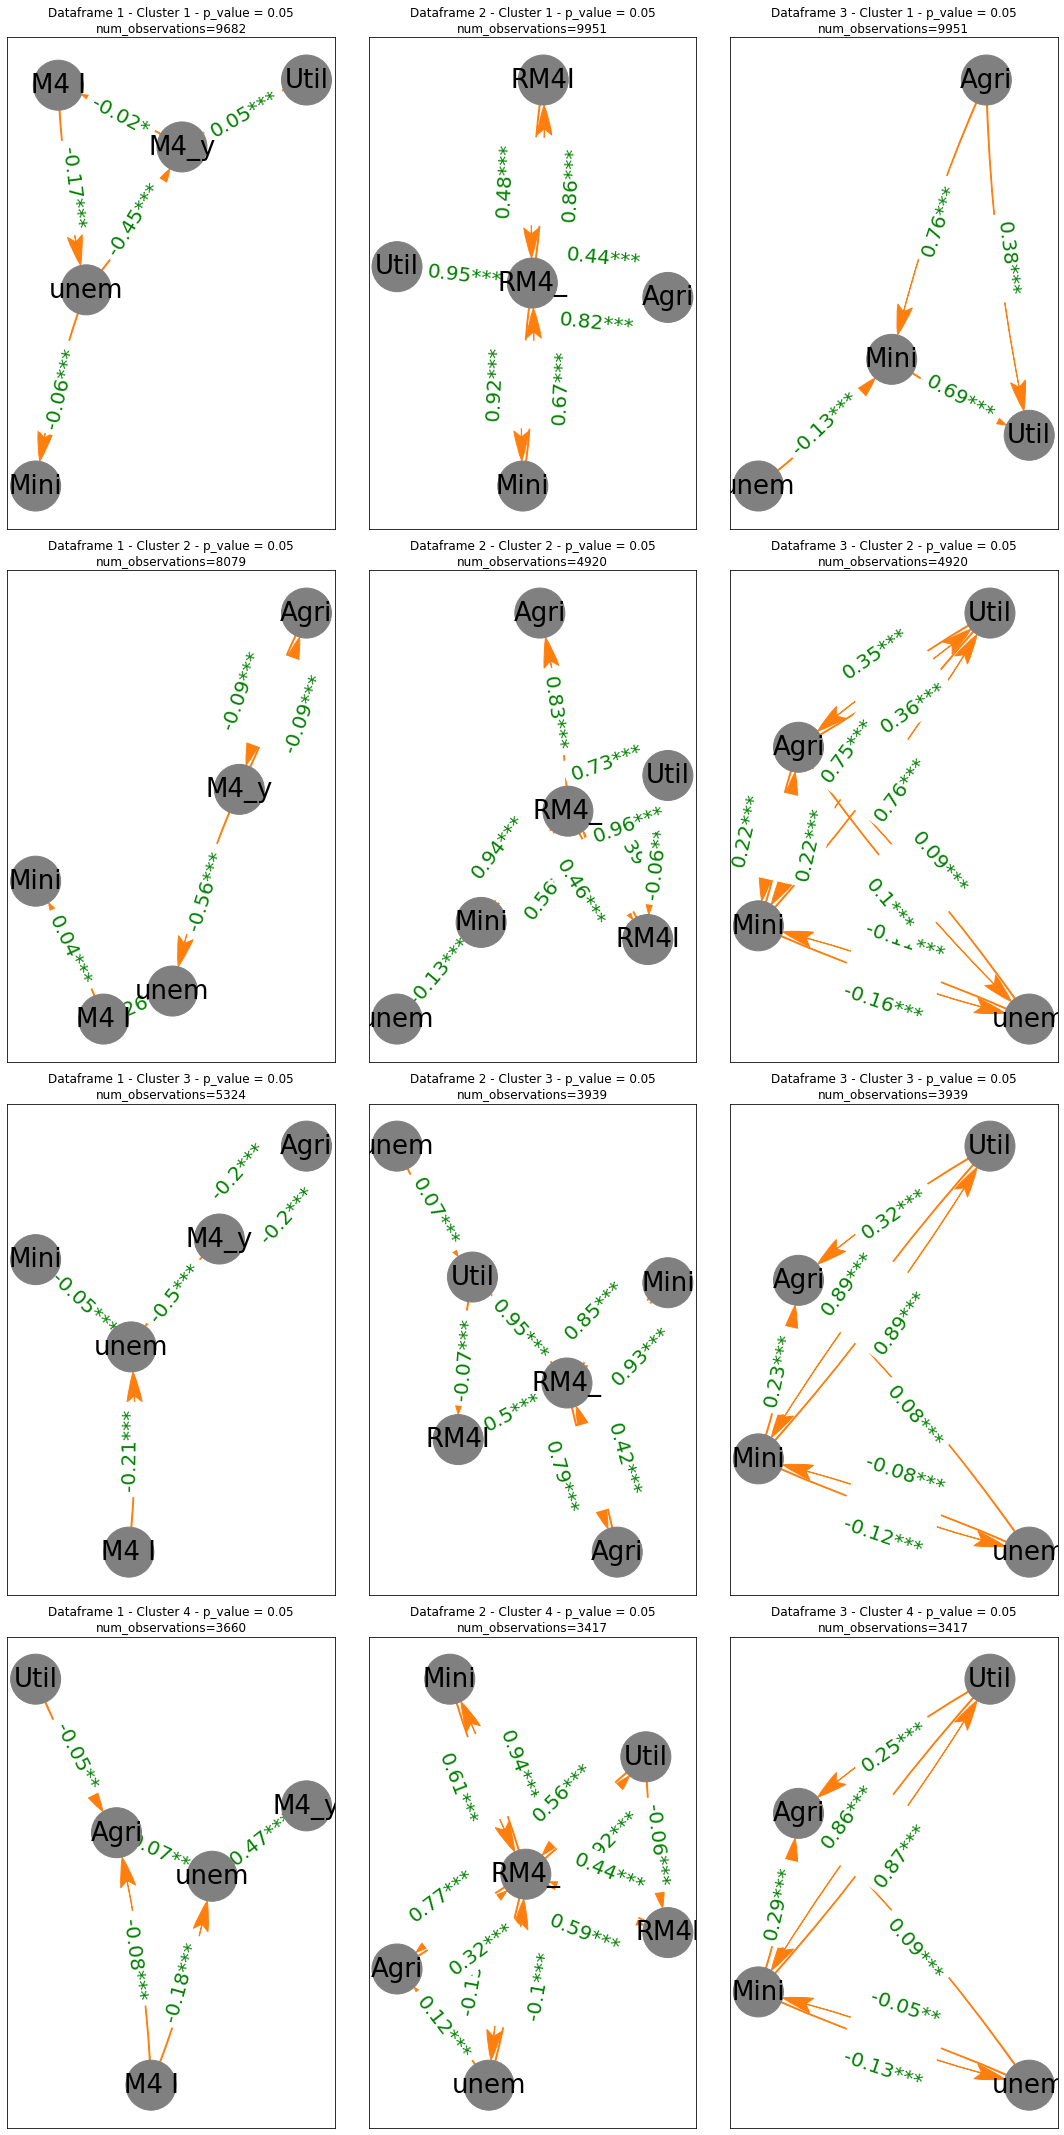

In [54]:
# Specify the absolute path for the output PDF file
pdf_file_path = "DAGs diff nominal vs diff real with clusters.pdf"
pp = PdfPages(pdf_file_path)

# Create a grid for the subplots
fig, axes = plt.subplots(4, len(dataframes), figsize=(5*len(dataframes), 30))

# Different PC algorithms to test
algorithms = ["orig"]

# Iterate over each dataframe
for idx, dataframe in enumerate(dataframes):
    # Get clustered dataframes for the current dataframe
    clustered_dfs = create_cluster_dags(dataframe)

    # Iterate over clustered dataframes and determine p-values dynamically
    for cluster_idx, cluster_df in enumerate(clustered_dfs):
        n = cluster_df.shape[0]  # Number of observations for the current cluster
        p_value = determine_p_value(n)

        # Iterate over different PC algorithms
        for algorithm in algorithms:
            c = PC(cluster_df)
            model = c.estimate(return_type='pdag', variant=algorithm, significance_level=p_value, ci_test='pearsonr')
            edges = model.edges

            # Create DAG for the current cluster, p-value, and algorithm using the modified graph_DAG function
            graph_DAG_cluster(edges, cluster_df, title=f'Dataframe {idx + 1} - Cluster {cluster_idx + 1} - p_value = {p_value}\nnum_observations={n}'
                      , algorithm=algorithm, ax=axes[cluster_idx, idx])

# Save the figure to the PDF
pp.savefig(fig, bbox_inches='tight')

pp.close()
plt.show()


In [55]:
edges_dct = get_edges_dict(dataframes)

Working for n conditional variables: 4:  80%|███████████████████████████████████▏        | 4/5 [00:00<00:00, 98.24it/s]


In [56]:
col_shared_edges=get_col_shared_edges(edges_dct)

In [57]:
row_shared_edges=get_row_shared_edges(edges_dct)
row_shared_edges

{0: [], 1: [], 2: [], 3: [('Agri', 'unem')]}

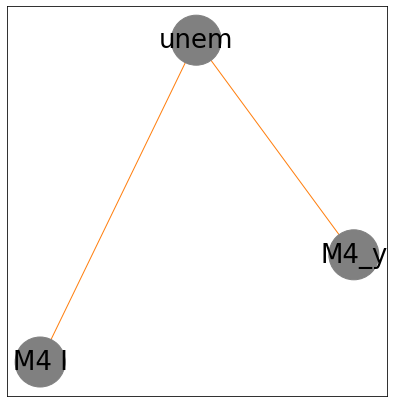

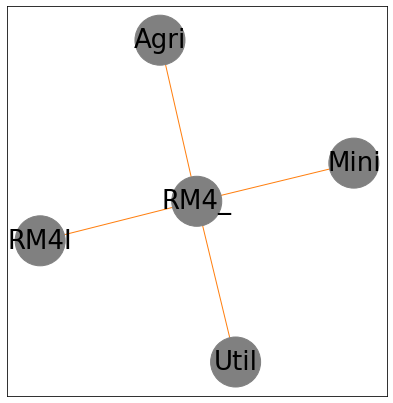

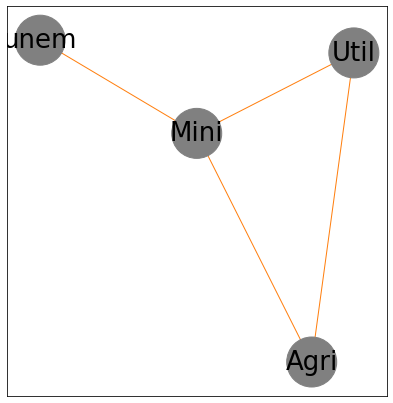

In [58]:
plot_shared_edges(col_shared_edges)

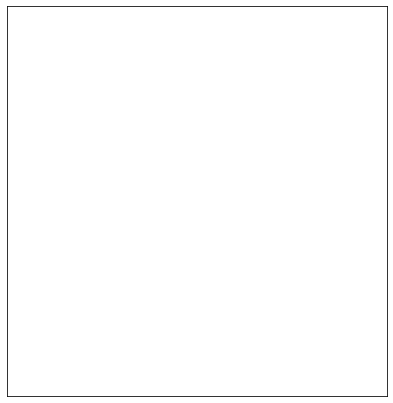

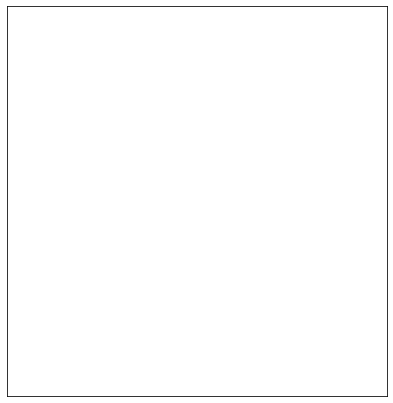

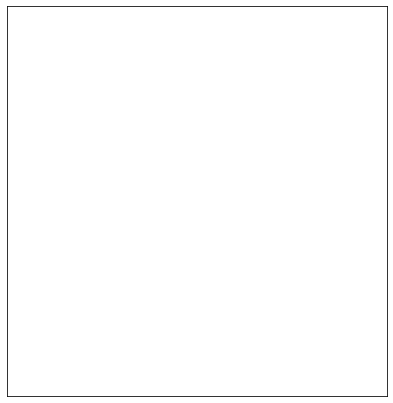

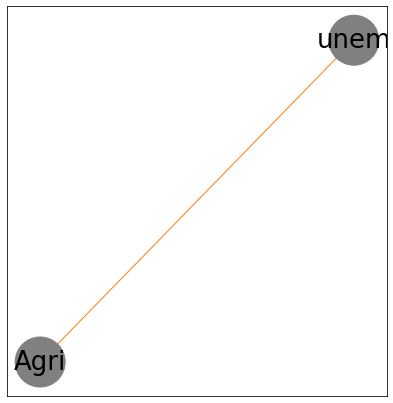

In [59]:
plot_shared_edges(row_shared_edges)

In [ ]:
def all_results(dfs):
    # Specify the absolute path for the output PDF file
    pdf_file_path = "DAGs diff nominal vs diff real with clusters.pdf"
    pp = PdfPages(pdf_file_path)

    # Create a grid for the subplots
    fig, axes = plt.subplots(4, len(dataframes), figsize=(5*len(dataframes), 30))

    # Different PC algorithms to test
    algorithms = ["orig"]

    # Iterate over each dataframe
    for idx, dataframe in enumerate(dataframes):
        # Get clustered dataframes for the current dataframe
        clustered_dfs = create_cluster_dags(dataframe)

        # Iterate over clustered dataframes and determine p-values dynamically
        for cluster_idx, cluster_df in enumerate(clustered_dfs):
            n = cluster_df.shape[0]  # Number of observations for the current cluster
            p_value = determine_p_value(n)

            # Iterate over different PC algorithms
            for algorithm in algorithms:
                c = PC(cluster_df)
                model = c.estimate(return_type='pdag', variant=algorithm, significance_level=p_value, ci_test='pearsonr')
                edges = model.edges

                # Create DAG for the current cluster, p-value, and algorithm using the modified graph_DAG function
                graph_DAG_cluster(edges, cluster_df, title=f'Dataframe {idx + 1} - Cluster {cluster_idx + 1} - p_value = {p_value}\nnum_observations={n}'
                          , algorithm=algorithm, ax=axes[cluster_idx, idx])

    # Save the figure to the PDF
    pp.savefig(fig, bbox_inches='tight')

    pp.close()
    plt.show()
    edges_dct = get_edges_dict(dataframes)
    col_shared_edges=get_col_shared_edges(edges_dct)
    row_shared_edges=get_row_shared_edges(edges_dct)
    plot_shared_edges(col_shared_edges)
    plot_shared_edges(row_shared_edges)
    
## Superstructure, fill out details . . .    
for nom_real in ("Real", "Nominal"):
    for diff_rate in ("Rates", "Diff"):

        # List of dataframes
        dataframes = [nr_13, rr_23, rr_24]

        # List of p-values for each dataframe
        p_values_list = [0.1, 0.05, 0.01, 0.001]  # Updated to include p-values for each dataframe

        # Define names for the output files based on dataframes
        output_names = [f'clusters_b{i+1}' for i in range(len(dataframes))]




In [60]:
kml3d_ai_level22.columns

Index(['Agri', 'Mini', 'Util', 'RM4_', 'RM4I', 'unem', 'clusters'], dtype='object')

In [61]:
def formatted_scatter_matrix(data,fig_len = 15,
                             c = "C0",
                            alpha = .1, pp = False):
        plt.rcParams.update({'font.size': 10})  

        fig, ax = plt.subplots(figsize = ((fig_len, fig_len)))  
        pd.plotting.scatter_matrix(data, color = c, 
                           alpha = .2, 
                           s = 200 / len(data.keys()), ax=ax)  
        plt.show()

In [62]:
plot_df = kml3d_ai_level22
clusters = plot_df["clusters"].unique()
plot_df["Cluster Color"] = ""
for i in clusters:
    plot_df["Cluster Color"][plot_df["clusters"] == i] = f"C{i}" 
plot_df

C:\Users\abiodun.idowu\Anaconda3\envs\python37\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


Agri      Mini      Util      RM4_       RM4I      unem  \
FIPS_y                                                                 
1001.0   0.078192 -0.322415 -1.700491 -0.939906  -0.872099  0.192308   
1001.0  -0.355243  0.495069  0.652586  0.221168   0.291269 -0.284615   
1001.0  -0.136923 -0.315151 -0.828012 -0.081404  -0.089440 -0.930769   
1001.0   0.283899  0.379960  0.952260  0.283377   0.305747 -0.469231   
1001.0  -0.440884 -0.166553 -0.215945  0.086412   0.049064  0.061538   
...           ...       ...       ...       ...        ...       ...   
56045.0 -4.845869 -5.193926 -5.253729 -4.942918 -10.385256  1.646154   
56045.0  2.397955  1.837275  1.995132  1.827574   8.783881 -0.923077   
56045.0  0.202471  0.601261  0.476881  0.394699   0.539095 -0.546154   
56045.0 -0.263437  0.434140  0.561532  0.586912   0.394453 -0.546154   
56045.0  0.097576 -0.468168 -0.215152 -0.034489   0.053008  0.876923   

         clusters Cluster Color  
FIPS_y                           
1001.0          1            C1  
1001.0          1            C1  
1001.0          1            C1  
1001.0          1            C1  
1001.0          1            C1  
...           ...           ...  
56045.0         4            C4  
56045.0         4            C4  
56045.0         4            C4  
56045.0         4            C4  
56045.0         4            C4  

[22227 rows x 8 columns]

C:\Users\abiodun.idowu\Anaconda3\envs\python37\lib\site-packages\ipykernel_launcher.py:9: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  if __name__ == '__main__':


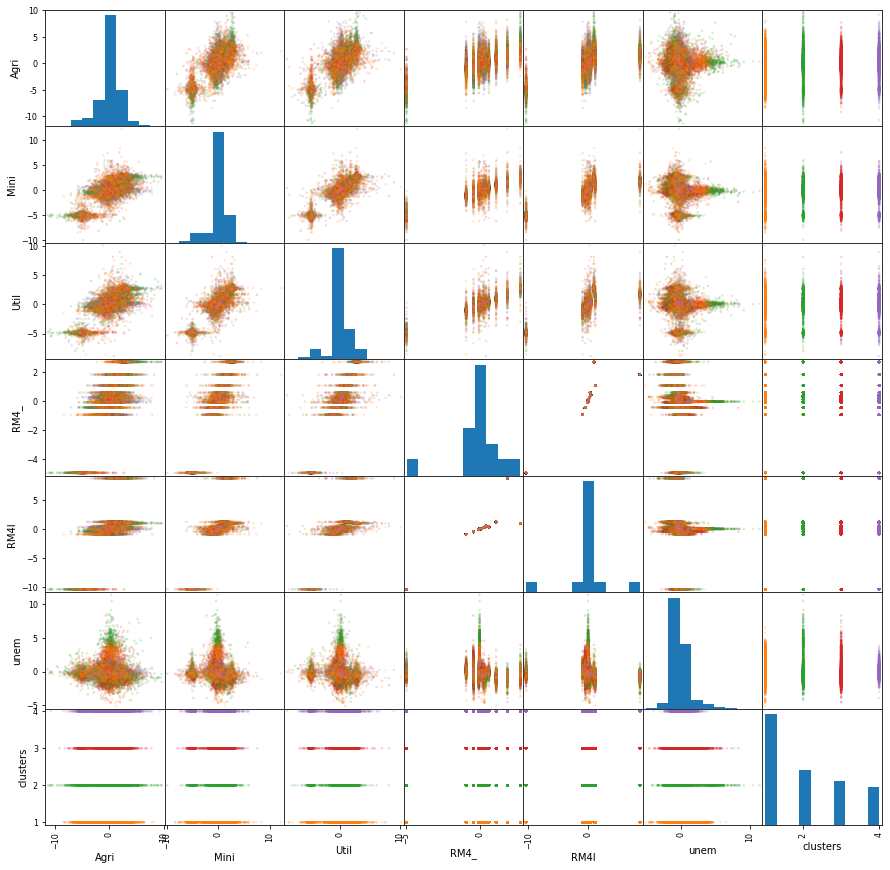

In [63]:
formatted_scatter_matrix(plot_df, c =plot_df["Cluster Color"],fig_len = 15)

In [64]:
nr1_df = nr_11
nr2_df = nr_12
nr3_df = nr_13
nr4_df = nr_14
nr5_df = rr_21
nr6_df = rr_22
nr7_df = rr_23
nr8_df = rr_24

In [65]:
dfs = [nr1_df, nr2_df, nr3_df, nr4_df, nr5_df, nr6_df, nr7_df, nr8_df]

for df in dfs:
    clusters = df["clusters"].unique()
    df["Cluster Color"] = ""
    for i in clusters:
        df.loc[df["clusters"] == i, "Cluster Color"] = f"C{i}"


C:\Users\abiodun.idowu\Anaconda3\envs\python37\lib\site-packages\ipykernel_launcher.py:9: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  if __name__ == '__main__':


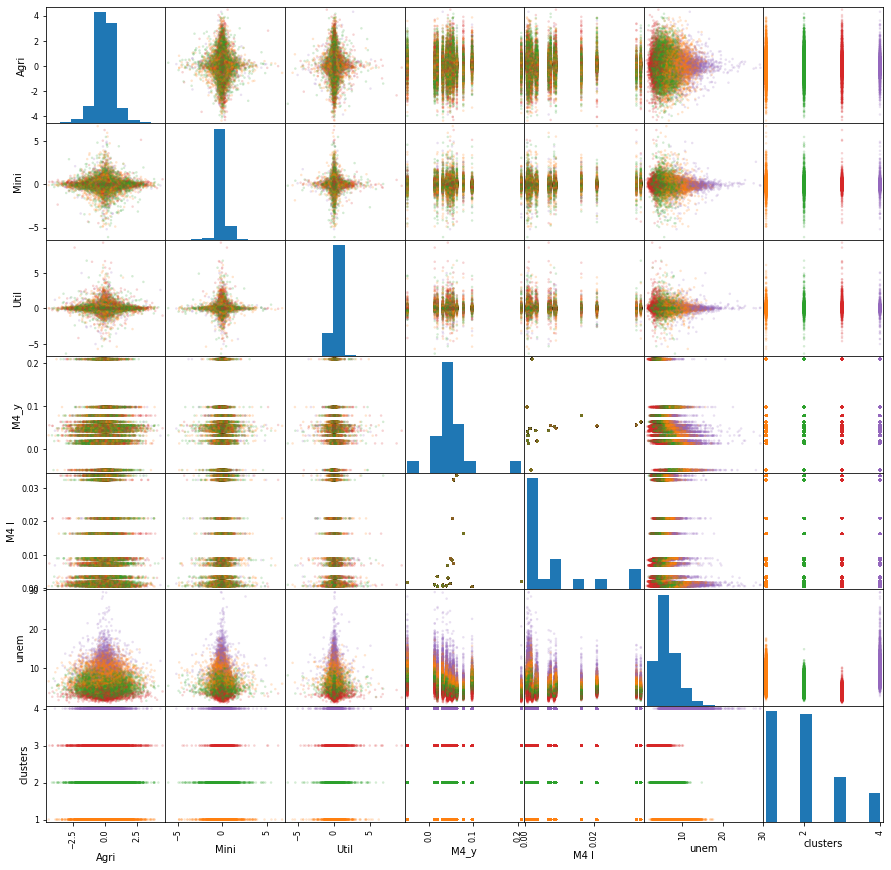

In [66]:
formatted_scatter_matrix(nr1_df, c =nr1_df["Cluster Color"],fig_len = 15)

C:\Users\abiodun.idowu\Anaconda3\envs\python37\lib\site-packages\ipykernel_launcher.py:9: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  if __name__ == '__main__':


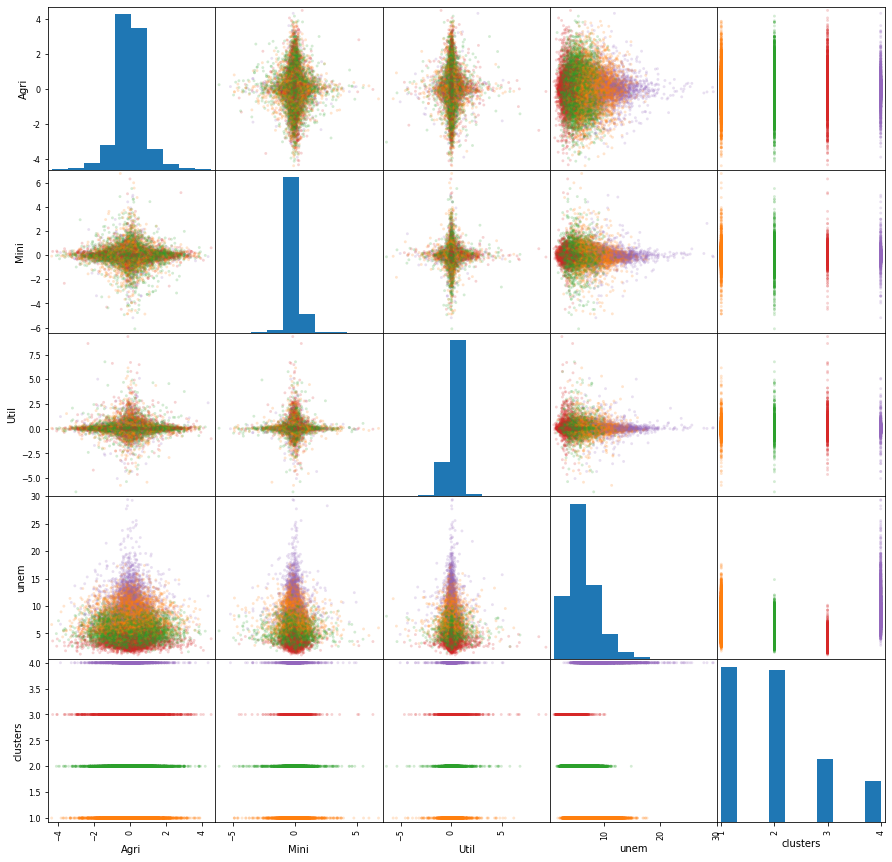

In [67]:
formatted_scatter_matrix(nr2_df, c =nr1_df["Cluster Color"],fig_len = 15)

C:\Users\abiodun.idowu\Anaconda3\envs\python37\lib\site-packages\ipykernel_launcher.py:8: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  


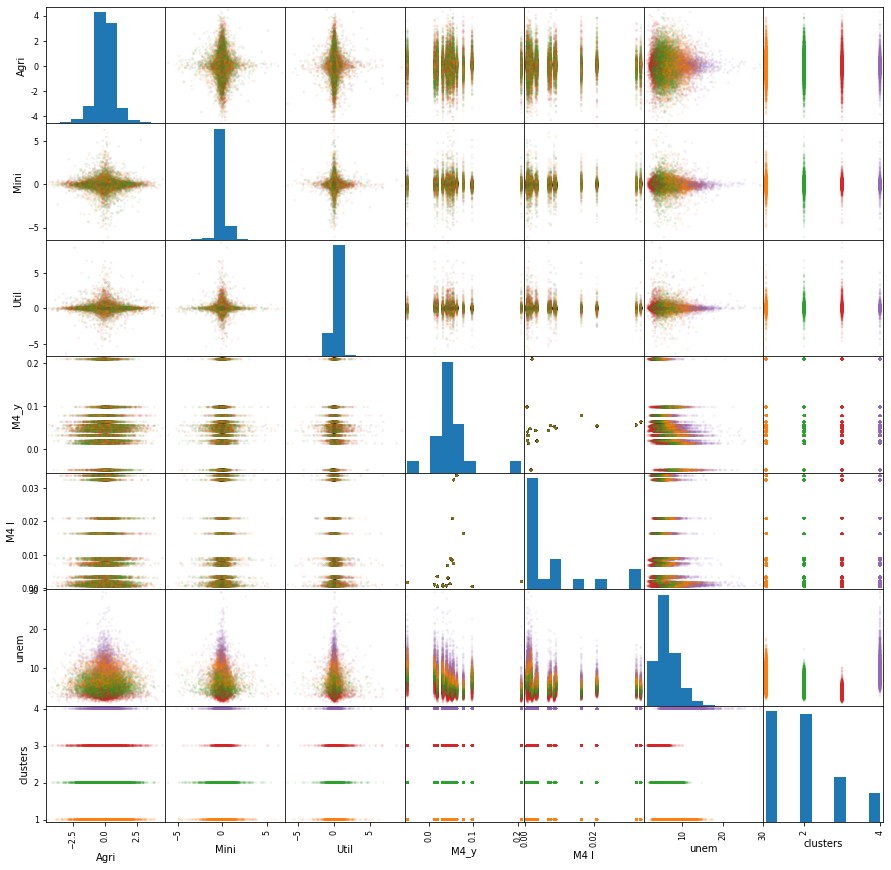

In [68]:
def formatted_scatter_matrixv1(data, fig_len=15, colors=None, alpha=0.1, pp=False):
    plt.rcParams.update({'font.size': 10})  

    if colors is None:
        colors = ["C0"] * len(data)

    fig, ax = plt.subplots(figsize=(fig_len, fig_len))  
    pd.plotting.scatter_matrix(data, color=colors, alpha=alpha, s=200 / len(data.keys()), ax=ax)  
    plt.show()

# Assuming nr1_df["Cluster Color"] contains the colors for each cluster
formatted_scatter_matrixv1(nr1_df, fig_len=15, colors=nr1_df["Cluster Color"])


C:\Users\abiodun.idowu\Anaconda3\envs\python37\lib\site-packages\ipykernel_launcher.py:9: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  if __name__ == '__main__':


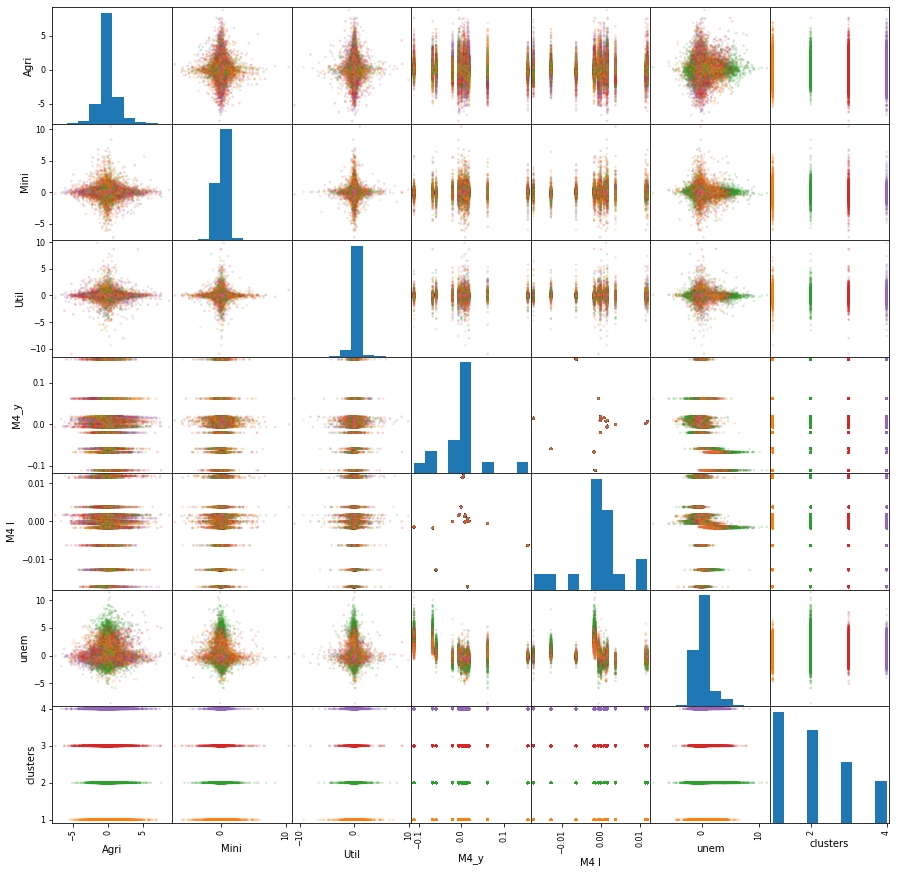

In [69]:
formatted_scatter_matrix(nr3_df, c =nr3_df["Cluster Color"],fig_len = 15)

C:\Users\abiodun.idowu\Anaconda3\envs\python37\lib\site-packages\ipykernel_launcher.py:9: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  if __name__ == '__main__':


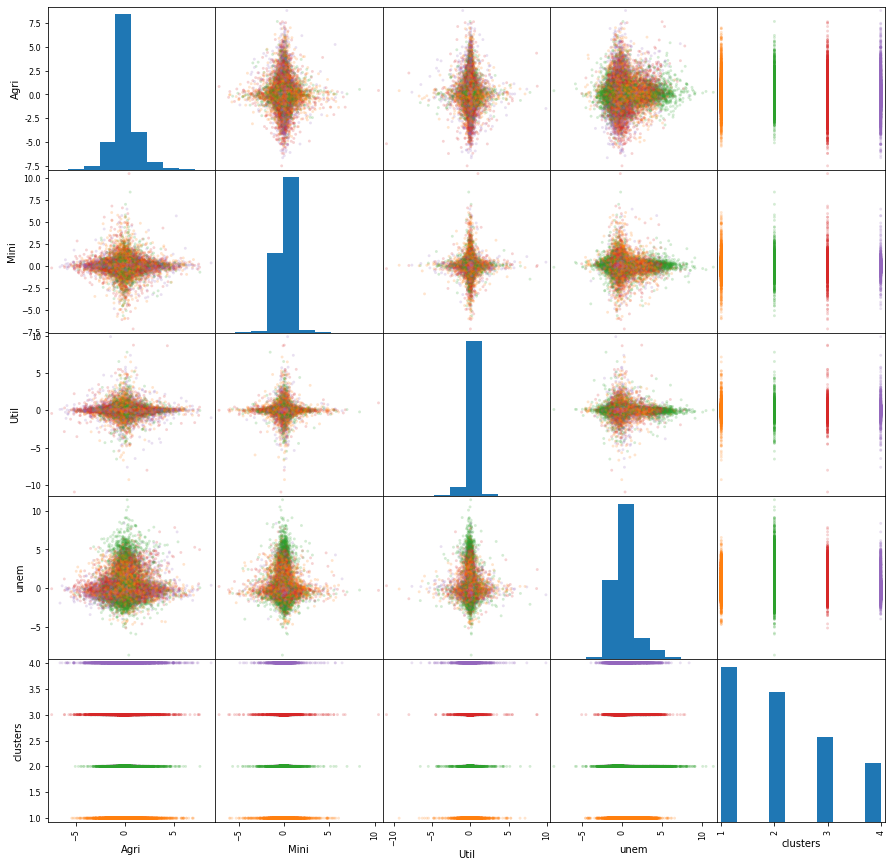

In [70]:
formatted_scatter_matrix(nr4_df, c =nr4_df["Cluster Color"],fig_len = 15)

C:\Users\abiodun.idowu\Anaconda3\envs\python37\lib\site-packages\ipykernel_launcher.py:9: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  if __name__ == '__main__':


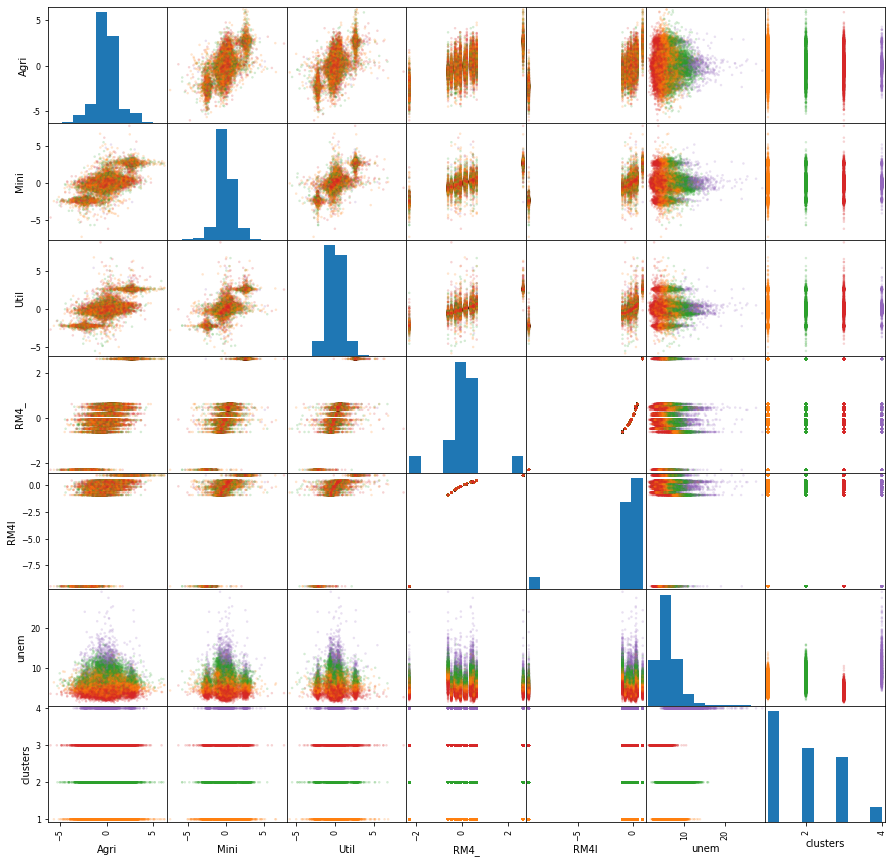

In [71]:
formatted_scatter_matrix(nr5_df, c =nr5_df["Cluster Color"],fig_len = 15)

C:\Users\abiodun.idowu\Anaconda3\envs\python37\lib\site-packages\ipykernel_launcher.py:9: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  if __name__ == '__main__':


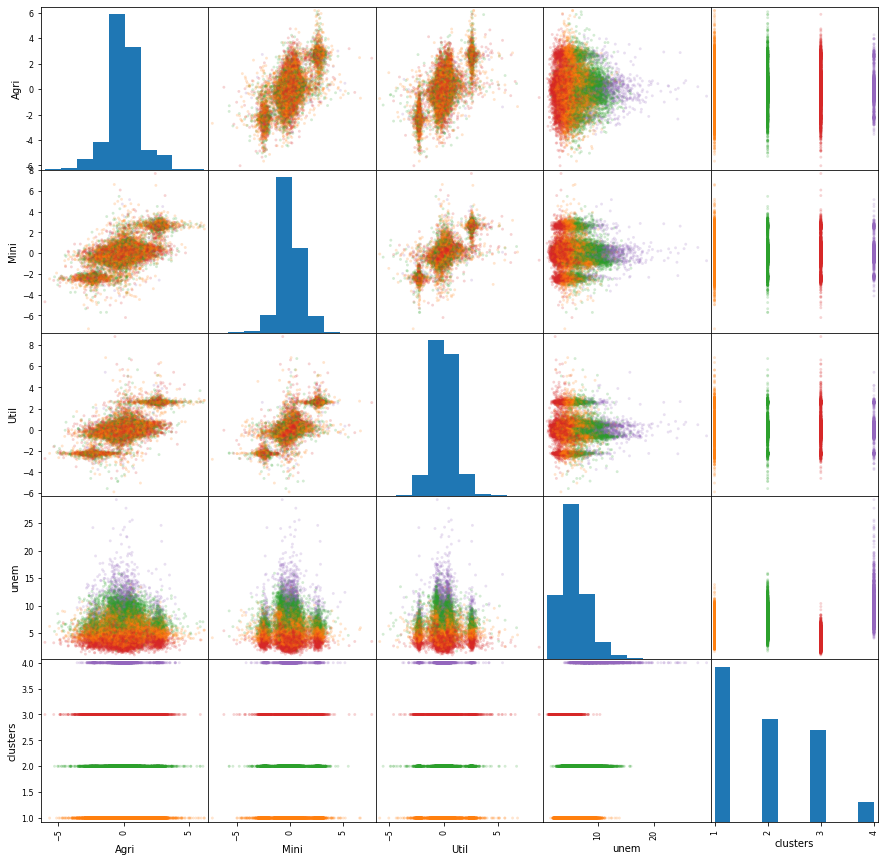

In [72]:
formatted_scatter_matrix(nr6_df, c =nr6_df["Cluster Color"],fig_len = 15)

C:\Users\abiodun.idowu\Anaconda3\envs\python37\lib\site-packages\ipykernel_launcher.py:9: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  if __name__ == '__main__':


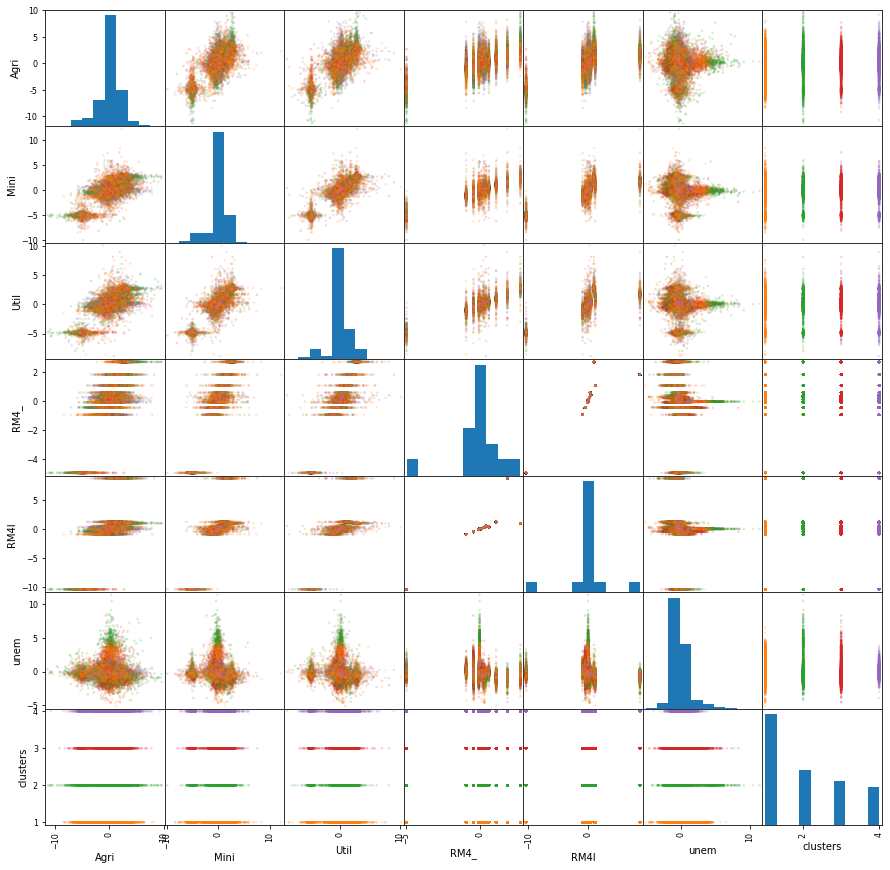

In [73]:
formatted_scatter_matrix(nr7_df, c =nr7_df["Cluster Color"],fig_len = 15)

C:\Users\abiodun.idowu\Anaconda3\envs\python37\lib\site-packages\ipykernel_launcher.py:9: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  if __name__ == '__main__':


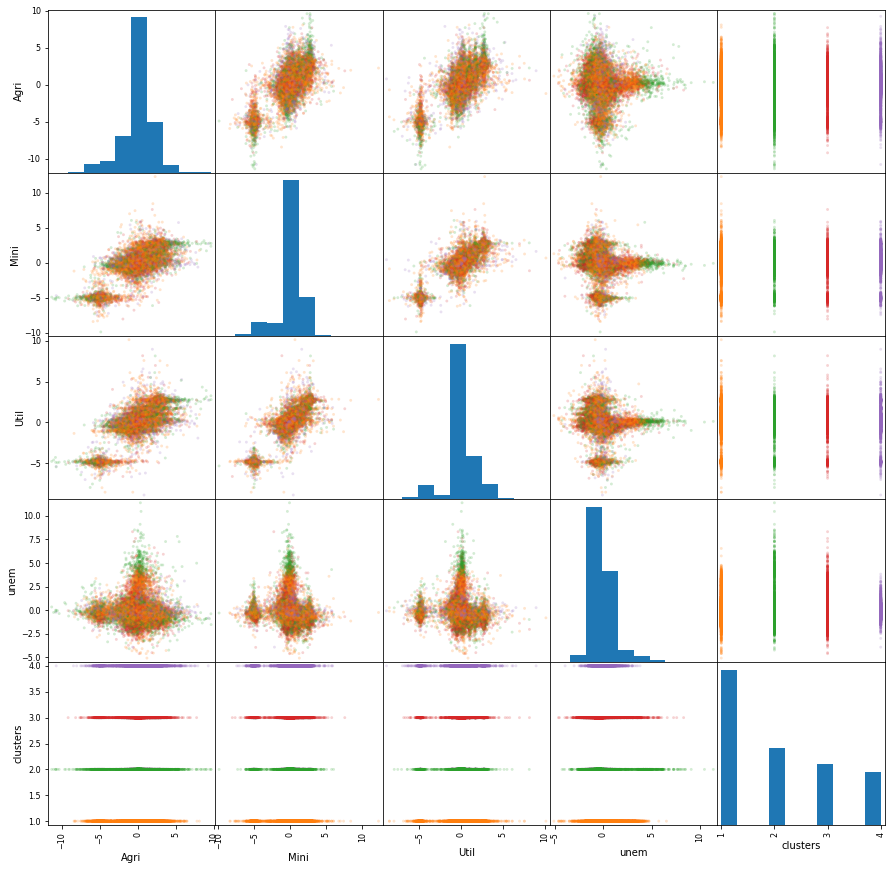

In [74]:
formatted_scatter_matrix(nr8_df, c =nr8_df["Cluster Color"],fig_len = 15)

In [75]:
plot_df1["Cluster"] = np.nan
plot_df1

Agri      Mini      Util      M4_y      M4 I  \
FIPS_y  TimePeriod                                                     
1001.0  2002       -0.217648 -0.419451  0.835570  0.055668  0.007415   
        2003        0.793538  0.191126  0.068072  0.048754  0.008946   
        2004        0.222678  0.470578  0.505041  0.054306  0.020890   
        2005        0.169133  0.238805 -0.239593  0.056279  0.032386   
        2006        0.176881  0.342614  0.436516  0.063506  0.033668   
...                      ...       ...       ...       ...       ...   
56045.0 2016       -0.209103 -0.018912 -0.193847  0.043399  0.003105   
        2017        0.360970 -0.009520 -0.026597  0.043091  0.006836   
        2018        0.178369  0.206669  0.065212  0.052718  0.008433   
        2019       -0.516320  0.209558  0.195492  0.208378  0.002033   
        2020       -0.494913 -0.334780 -0.095830  0.097720  0.000516   

                        unem  Cluster  
FIPS_y  TimePeriod                     
1001.0  2002        4.807692      NaN  
        2003        5.000000      NaN  
        2004        4.715385      NaN  
        2005        3.784615      NaN  
        2006        3.315385      NaN  
...                      ...      ...  
56045.0 2016        5.007692      NaN  
        2017        4.084615      NaN  
        2018        3.538462      NaN  
        2019        2.992308      NaN  
        2020        3.869231      NaN  

[30871 rows x 7 columns]

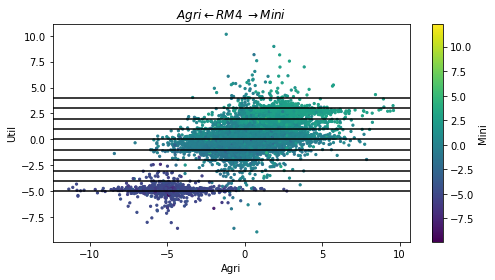

In [76]:
fig,ax = plt.subplots(figsize = (8,4))
kml3d_ai_level22.plot.scatter(x = "Agri", y = "Util", c = "Mini", cmap = "viridis", s = 5, ax = ax)
ax.set_title("$Agri \\leftarrow RM4_ \\rightarrow Mini$")
for i in range(-5,5): ax.axhline(i, c = "k")

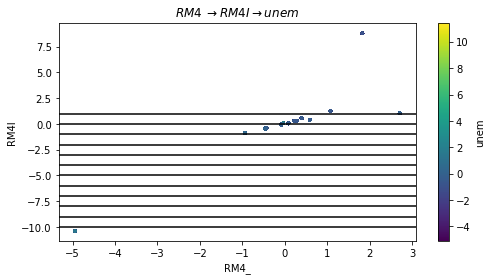

In [77]:
fig,ax = plt.subplots(figsize = (8,4))
kml3d_ai_level22.plot.scatter(x = "RM4_", y = "RM4I", c = "unem", cmap = "viridis", s = 5, ax = ax)
ax.set_title("$RM4_ \\rightarrow RM4I \\rightarrow unem$")
for i in range(-10,2): ax.axhline(i, c = "k")

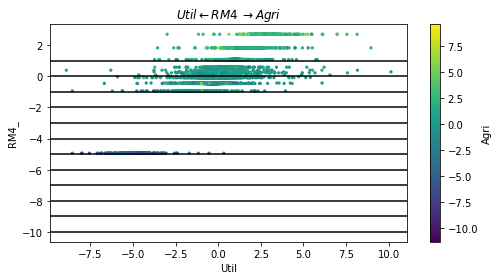

In [78]:
fig,ax = plt.subplots(figsize = (8,4))
kml3d_ai_level22.plot.scatter(x = "Util", y = "RM4_", c = "Agri", cmap = "viridis", s = 5, ax = ax)
ax.set_title("$Util \\leftarrow RM4_ \\rightarrow Agri$")
for i in range(-10,2): ax.axhline(i, c = "k")

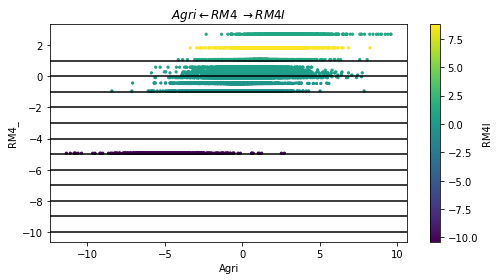

In [79]:
fig,ax = plt.subplots(figsize = (8,4))
kml3d_ai_level22.plot.scatter(x = "Agri", y = "RM4_", c = "RM4I", cmap = "viridis", s = 5, ax = ax)
ax.set_title("$Agri \\leftarrow RM4_ \\rightarrow RM4I$")
for i in range(-10,2): ax.axhline(i, c = "k")

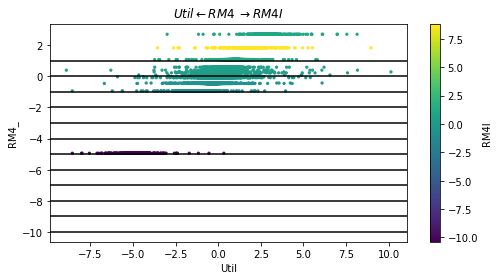

In [80]:
fig,ax = plt.subplots(figsize = (8,4))
kml3d_ai_level22.plot.scatter(x = "Util", y = "RM4_", c = "RM4I", cmap = "viridis", s = 5, ax = ax)
ax.set_title("$Util \\leftarrow RM4_ \\rightarrow RM4I$")
for i in range(-10,2): ax.axhline(i, c = "k")